In [151]:
from tools.utils import *
from tools.hom_networks import *

import torch

from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# Random
seed = 42

# Model
hidden_channels = 256
num_classes = 6
num_layers = 2
aggr = 'mean'
dropout = 0.4
use_skip_connections = True
batch_size = 8
epochs = 45
decay = 5e-4
lr = 3e-4
maxlr = 3e-4

# Preprocess

In [153]:
# Load the ENZYMES dataset
hom_dataset = TUDataset(root='data', name='ENZYMES')                          # This has 3 one-hot encodings
hom_dataset_attr = TUDataset(root='data', name='ENZYMES', use_node_attr=True) # This has 3 one-hot encodings and 18 features

In [154]:
def normalize_enzymes_data(data):
    data = data.clone()
    if hasattr(data, 'x') and data.x is not None:
        x = data.x
        feats = x[:, :18]
        mean = feats.mean(dim=0)
        std = feats.std(dim=0, unbiased=False)
        std[std == 0] = 1.0
        normalized_feats = (feats - mean) / std
        x[:, :18] = normalized_feats
        data.x = x
    return data

# Normalize features
normalized_hom_dataset_attr = [normalize_enzymes_data(hom_data) for hom_data in hom_dataset_attr]

In [155]:
# Create splits
labels = [data.y.item() for data in normalized_hom_dataset_attr]

train_set, temp_set = train_test_split(
    normalized_hom_dataset_attr, 
    test_size=0.3, 
    stratify=labels,
    random_state=seed
    
)

temp_labels = [data.y.item() for data in temp_set]
valid_set, test_set = train_test_split(
    temp_set, 
    test_size=0.5, 
    stratify=temp_labels,
    random_state=seed
)

# train_loader is defined at each experiment for reproducibility
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Tuning HomoGNN

Epoch 1/45
Train Loss: 1.8073 | Validation Loss: 1.7984
Train Acc: 0.1667 | Validation Acc: 0.1667
Train F1: 0.0476 | Validation F1: 0.0476

Epoch 2/45
Train Loss: 1.8034 | Validation Loss: 1.7935
Train Acc: 0.1690 | Validation Acc: 0.1667
Train F1: 0.0524 | Validation F1: 0.0476

Epoch 3/45
Train Loss: 1.7959 | Validation Loss: 1.7902
Train Acc: 0.1738 | Validation Acc: 0.1556
Train F1: 0.0639 | Validation F1: 0.0449

Epoch 4/45
Train Loss: 1.7978 | Validation Loss: 1.7880
Train Acc: 0.1619 | Validation Acc: 0.2333
Train F1: 0.0856 | Validation F1: 0.1523

Epoch 5/45
Train Loss: 1.7906 | Validation Loss: 1.7866
Train Acc: 0.1952 | Validation Acc: 0.1667
Train F1: 0.1709 | Validation F1: 0.0485

Epoch 6/45
Train Loss: 1.7913 | Validation Loss: 1.7834
Train Acc: 0.1810 | Validation Acc: 0.2333
Train F1: 0.1360 | Validation F1: 0.1204

Epoch 7/45
Train Loss: 1.7901 | Validation Loss: 1.7796
Train Acc: 0.1667 | Validation Acc: 0.2000
Train F1: 0.1117 | Validation F1: 0.1072

Epoch 8/45
Tr

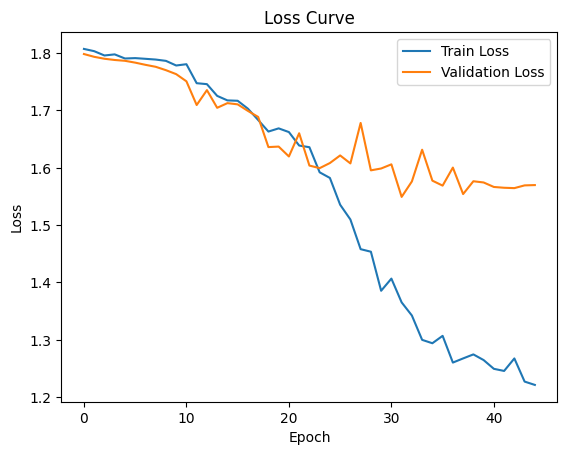

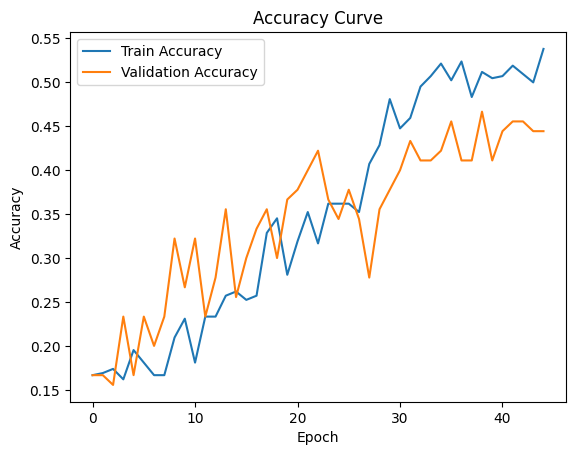

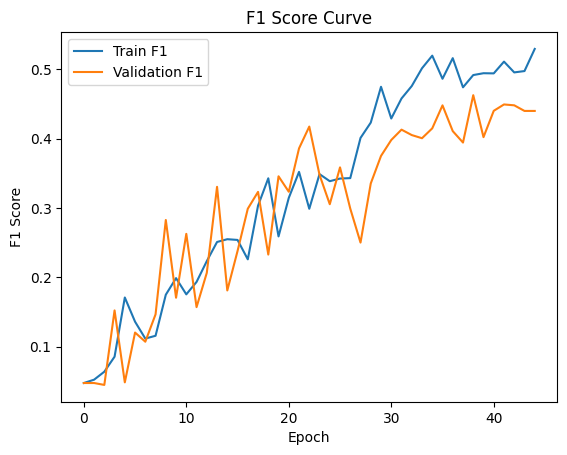

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.8073,1.7984,0.1667,0.1667,0.0476,0.0476
1,2,1.8034,1.7935,0.1690,0.1667,0.0524,0.0476
2,3,1.7959,1.7902,0.1738,0.1556,0.0639,0.0449
3,4,1.7978,1.7880,0.1619,0.2333,0.0856,0.1523
4,5,1.7906,1.7866,0.1952,0.1667,0.1709,0.0485
5,6,1.7913,1.7834,0.1810,0.2333,0.1360,0.1204
6,7,1.7901,1.7796,0.1667,0.2000,0.1117,0.1072
7,8,1.7888,1.7761,0.1667,0.2333,0.1157,0.1466
8,9,1.7865,1.7702,0.2095,0.3222,0.1749,0.2827
9,10,1.7784,1.7633,0.2310,0.2667,0.1988,0.1706


In [156]:
experiment_name = f"ENZYMES-HomoGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{aggr} aggr-{dropout} dropout-use skip {use_skip_connections}-{lr} lr-{maxlr} maxlr-{decay} decay-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HomoGNN_GraphConv(hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, aggr=aggr, dropout=dropout, use_skip_connections=use_skip_connections).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
model
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, hom_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, hom_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)